## 1. Preprocessing

In [1]:
from imp import reload
from sqlalchemy import create_engine
from src import config, data_utils, preprocessing
import pandas as pd

C:\Users\Cesar_Maydana\AppData\Local\Temp\ipykernel_32516\2797311845.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


### Getting the data

In [2]:
app_train, app_test = data_utils.get_datasets()
app_train.columns

columns Index(['passenger_count', 'PULocationID', 'DOLocationID', 'payment_type',
       'improvement_surcharge', 'total_amount', 'airport_fee',
       'duration_in_minutes', 'pickup_year', 'pickup_day',
       'pickup_day_of_week', 'pickup_hour', 'pickup_minute'],
      dtype='object')


Index(['passenger_count', 'PULocationID', 'DOLocationID', 'payment_type',
       'improvement_surcharge', 'total_amount', 'airport_fee',
       'duration_in_minutes', 'pickup_year', 'pickup_day',
       'pickup_day_of_week', 'pickup_hour', 'pickup_minute'],
      dtype='object')

In [5]:
# Crear el motor de la base de datos
# Aquí estoy asumiendo que estás usando SQLite y que quieres guardar los datos en un archivo llamado `mydatabase.db`
#engine = create_engine(rf"sqlite:///{config.SQLITE_BD_ABSOLUTE_PATH}", echo=False)

# Guardar los DataFrames en la base de datos
#app_train.to_sql('app_train', engine, if_exists='replace', index=False)
#app_test.to_sql('app_test', engine, if_exists='replace', index=False)

In [3]:
app_train.shape 

(3400316, 13)

## Split targets from dataset

In [4]:
(
 X_train,
 y_train_total_amount,
 y_train_duration_in_minutes,
 X_test,
 y_test_total_amount,
 y_test_duration_in_minutes
) = data_utils.get_feature_target(app_train, app_test)

## Stract validation dataset

In [5]:
(
X_train,
X_val,
y_train_total_amount,
y_val_total_amount,
y_train_duration_in_minutes,
y_val_duration_in_minutes
) = data_utils.get_train_val_sets(X_train, y_train_total_amount, y_train_duration_in_minutes)

In [6]:
print(X_train.shape, X_val.shape, X_test.shape)

(2720252, 12) (680064, 12) (3400160, 12)


## Clear and encode datasets

In [6]:
reload(preprocessing)                

<module 'src.preprocessing' from 'c:\\Anyone\\repos\\Finall_project\\assignment\\taxi-price-predictor\\src\\preprocessing.py'>

In [6]:
X_train, X_val, X_test = preprocessing.preprocess_data(X_train, X_val, X_test)

Input train data shape:  (2720252, 11)
Input val data shape:  (680064, 11)
Input test data shape:  (3400160, 11) 



In [8]:
# Create a XGBoost matrices
import xgboost as xgb

x_train2 = xgb.DMatrix(X_train, label=y_train_duration_in_minutes)
X_val2 = xgb.DMatrix(X_val, label=y_val_duration_in_minutes)

In [9]:
parameters = {'learning_rate': 0.3,
              'max_depth': 6,
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight': 1,
              'gamma': 0,
              'random_state': 42,
              'eval_metric': 'rmse',
              'objective': 'reg:squarederror'}

In [6]:
import subprocess

command = f"{sys.executable} -m pip freeze > requirements2.txt"
subprocess.run(command, shell=True)

CompletedProcess(args='c:\\Anyone\\repos\\Finall_project\\env\\python.exe -m pip freeze > requirements2.txt', returncode=0)

In [12]:
model = xgb.train(parameters, 
                dtrain = x_train2, 
                num_boost_round=15, 
                evals=[(X_val2, 'duration_in_minutes')], 
                verbose_eval=10)

[0]	duration_in_minutes-rmse:51.90321
[10]	duration_in_minutes-rmse:51.14088
[14]	duration_in_minutes-rmse:51.12227


In [13]:
predictions = model.predict(X_val2)
predictions[:5]

array([ 6.206475,  7.701418,  9.543358, 12.56599 ,  4.823457],
      dtype=float32)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
print(round(mean_absolute_error(y_val_duration_in_minutes, predictions), 2))
print(round(mean_squared_error(y_val_duration_in_minutes, predictions), 2))
print(round(np.sqrt(mean_squared_error(y_val_duration_in_minutes, predictions)), 2))
print(round(r2_score(y_val_duration_in_minutes, predictions), 2))

6.06
2613.49
51.12
0.06


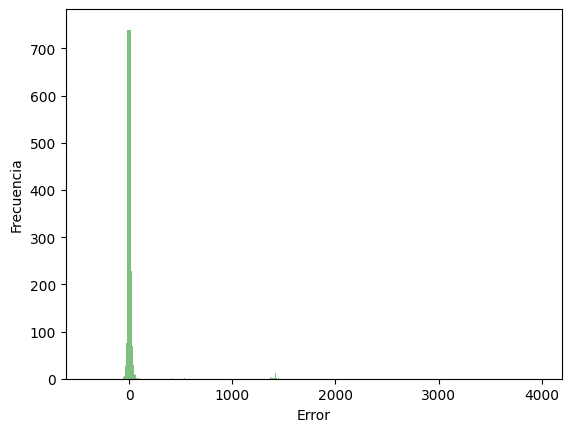

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Asumiendo que y_val2 son los valores reales
# Realizar las predicciones
predictions = model.predict(X_val2)

# Calcular los errores
errors = y_val_duration_in_minutes - predictions

# Calcular las frecuencias y los bordes de los bins
frequencies, bin_edges = np.histogram(errors, bins='auto')

# Filtrar los bins cuya frecuencia sea menor a 2000
filtered_bin_edges = bin_edges[:-1][frequencies < 750]
filtered_frequencies = frequencies[frequencies < 750]

# Crear una figura y un conjunto de subtramas
fig, ax = plt.subplots()

# Crear un histograma con los errores filtrados
# Usar np.diff(filtered_bin_edges) para obtener el ancho de los bins filtrados
# Agregar un último valor para que coincida con la longitud de filtered_bin_edges y filtered_frequencies
widths = np.append(np.diff(filtered_bin_edges), np.diff(filtered_bin_edges)[-1])

ax.bar(filtered_bin_edges, filtered_frequencies, width=widths, align="edge", alpha=0.5, color='g')

# Establecer las etiquetas de los ejes
ax.set_xlabel('Error')
ax.set_ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

## Models

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor
import xgboost as xgb
import pickle


# LightGBM Regressor (using validation set)
lgbm = LGBMRegressor(random_state=42)

# Train on training features and duration target
lgbm.fit(X_train, y_train_total_amount)

# Make predictions on validation set features
y_pred_lgbm = lgbm.predict(X_val)

# Evaluate on validation set - duration
r2_lgbm_val = r2_score(y_val_total_amount, y_pred_lgbm)
mse_lgbm_val = mean_squared_error(y_val_total_amount, y_pred_lgbm)

# Print validation set results (f-string for readability)
print(f"LightGBM Regressor (Validation) - R2: {r2_lgbm_val:.4f}, MSE: {mse_lgbm_val:.4f}")

# XGBoost Regressor (using validation set)
xgbr = xgb.XGBRegressor(random_state=42)

# Train on training features and duration target
xgbr.fit(X_train, y_train_duration_in_minutes)

# Make predictions on validation set features
y_pred_xgbr = xgbr.predict(X_val)

# Evaluate on validation set - duration
r2_xgbr_val = r2_score(y_val_duration_in_minutes, y_pred_xgbr)
mse_xgbr_val = mean_squared_error(y_val_duration_in_minutes, y_pred_xgbr)

#with open('time_model1.pkl', 'wb') as file:
#    pickle.dump(xgbr, file)

#with open('Rate.pkl', 'wb') as file:
#    pickle.dump(lgbm, file)


# Print validation set results (f-string for readability)
print(f"XGBoost Regressor (Validation) - R2: {r2_xgbr_val:.4f}, MSE: {mse_xgbr_val:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 829
[LightGBM] [Info] Number of data points in the train set: 2720252, number of used features: 11
[LightGBM] [Info] Start training from score 21.142774
LightGBM Regressor (Validation) - R2: 0.9260, MSE: 17.0264
XGBoost Regressor (Validation) - R2: 0.0554, MSE: 2612.3461


### Linear Regression

[[0.2        0.90458015 0.94656489 ... 1.         0.95652174 0.10169492]
 [0.         1.         0.87022901 ... 0.66666667 0.69565217 0.50847458]
 [0.2        0.61832061 0.33969466 ... 1.         0.91304348 0.33898305]
 ...
 [0.         0.29770992 0.59923664 ... 0.66666667 0.56521739 0.88135593]
 [0.         0.5        0.8740458  ... 0.33333333 0.43478261 0.96610169]
 [0.         0.32824427 0.79389313 ... 0.66666667 0.52173913 0.96610169]]


#### Total amount prediction

In [137]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from src.save_model import save_total_trip_model,save_duration_trip_model
import math

# Create a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train_total_amount)

save_total_trip_model(model)
# Predict using the model

y_pred_train = model.predict(X_train)
print('MAE:', mean_absolute_error(y_train_total_amount, y_pred_train))
print('MSE:', mean_squared_error(y_train_total_amount, y_pred_train))
print('RMSE:', math.sqrt(mean_squared_error(y_train_total_amount, y_pred_train)))
print('R2:', r2_score(y_train_total_amount, y_pred_train))
print('_________________________:')

y_pred_val = model.predict(X_val)
print('MAE:', mean_absolute_error(y_val_total_amount, y_pred_val))
print('MSE:', mean_squared_error(y_val_total_amount, y_pred_val))
print('RMSE:', math.sqrt(mean_squared_error(y_val_total_amount, y_pred_val)))
print('R2:', r2_score(y_val_total_amount, y_pred_val))

MAE: 8.499936202490034
MSE: 227.1152783615407
RMSE: 15.070344334537971
R2: 0.3392703528507055
_________________________:
MAE: 8.459752577545961
MSE: 204.6382722531288
RMSE: 14.305183405085334
R2: 0.35828908484859767


#### Trip duration prediction

In [138]:
# Create a linear regression model
model_duration = LinearRegression()

print(X_train.shape)
print(y_train_duration_in_minutes.shape)
# Fit the model
model_duration.fit(X_train, y_train_duration_in_minutes)

save_duration_trip_model(model_duration)
# Predict using the model

y_pred_train = model_duration.predict(X_train)
print('MAE:', mean_absolute_error(y_train_duration_in_minutes, y_pred_train))
print('MSE:', mean_squared_error(y_train_duration_in_minutes, y_pred_train))
print('RMSE:', math.sqrt(mean_squared_error(y_train_duration_in_minutes, y_pred_train)))
print('R2:', r2_score(y_train_duration_in_minutes, y_pred_train))
print('_________________________:')

y_pred_val = model_duration.predict(X_val)
print('MAE:', mean_absolute_error(y_val_duration_in_minutes, y_pred_val))
print('MSE:', mean_squared_error(y_val_duration_in_minutes, y_pred_val))
print('RMSE:', math.sqrt(mean_squared_error(y_val_duration_in_minutes, y_pred_val)))
print('R2:', r2_score(y_val_duration_in_minutes, y_pred_val))

(2767016, 11)
(2767016,)
MAE: 10.507362989449026
MSE: 2689.339306865035
RMSE: 51.85884019976763
R2: 0.017765573487283692
_________________________:
MAE: 10.524926375876877
MSE: 2739.279361595603
RMSE: 52.33812531602181
R2: 0.01666234906141406


### DecisionTreeRegressor

In [139]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

In [140]:
tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train, y_train_total_amount)

# Evaluate the model
y_pred_train_DTR = tree.predict(X_train)



print('MAE:', mean_absolute_error(y_train_total_amount, y_pred_train_DTR))
print('MSE:', mean_squared_error(y_train_total_amount, y_pred_train_DTR))
print('RMSE:', math.sqrt(mean_squared_error(y_train_total_amount, y_pred_train_DTR)))
print('R2:', r2_score(y_train_total_amount, y_pred_train_DTR))

y_pred_val_DTR = tree.predict(X_val)

print('val:')

print('MAE:', mean_absolute_error(y_val_total_amount, y_pred_val_DTR))
print('MSE:', mean_squared_error(y_val_total_amount, y_pred_val_DTR))
print('RMSE:', math.sqrt(mean_squared_error(y_val_total_amount, y_pred_val_DTR)))
print('R2:', r2_score(y_val_total_amount, y_pred_val_DTR))

MAE: 5.927281148257893
MSE: 128.48125407285585
RMSE: 11.334957171196363
R2: 0.6262190096532394
val:
MAE: 5.91380714453071
MSE: 108.65590724153505
RMSE: 10.423814428582995
R2: 0.6592735029236191


### XGBRegressor

In [143]:
import xgboost as xgb
print('__version__',xgb.__version__)
from sklearn.datasets import make_regression
#XGBRegressor
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=1, random_state=42,
                               n_estimators=500, max_depth=5, learning_rate=00.1, 
                               subsample=0.8, colsample_bytree=0.8)

# Fit the model
model_xgb.fit(X_train, y_train_total_amount)

y_pred_train_xgb = model.predict(X_train)

print('MAE:', mean_absolute_error(y_train_total_amount, y_pred_train_xgb))
print("MSE:", mean_squared_error(y_train_total_amount, y_pred_train_xgb))
print('RMSE:', math.sqrt(mean_squared_error(y_train_total_amount, y_pred_train_xgb)))
r2 = r2_score(y_train_total_amount, y_pred_train_xgb)
print(f"R2: {r2_score(y_train_total_amount, y_pred_train_xgb):.2f}")

# Predicting the Test set results
y_pred_val_xgb = model.predict(X_val)

print("Val:")
print('MAE:', mean_absolute_error(y_val_total_amount, y_pred_val_xgb))
print("MSE:", mean_squared_error(y_val_total_amount, y_pred_val_xgb))
print('RMSE:', math.sqrt(mean_squared_error(y_val_total_amount, y_pred_val_xgb)))
print(f"R2: {r2_score(y_val_total_amount, y_pred_val_xgb):.2f}")

__version__ 2.0.3
MAE: 8.499936202490034
MSE: 227.1152783615407
RMSE: 15.070344334537971
R2: 0.34
Val:
MAE: 8.459752577545961
MSE: 204.6382722531288
RMSE: 14.305183405085334
R2: 0.36


#### Random Forest Regressor

In [150]:
rf_reg = RandomForestRegressor(n_estimators=6, max_depth=5, random_state=42, n_jobs=1)
rf_reg.fit(X_train, y_train_total_amount)

# Evaluate the model
y_pred_train_RFR = rf_reg.predict(X_train)

print('MAE:', mean_absolute_error(y_train_total_amount, y_pred_train_RFR))
print("MSE:", mean_squared_error(y_train_total_amount, y_pred_train_RFR))
print('RMSE:', math.sqrt(mean_squared_error(y_train_total_amount, y_pred_train_RFR)))
r2 = r2_score(y_train_total_amount, y_pred_train_RFR)
print(f"R2: {r2_score(y_train_total_amount, y_pred_train_RFR):.2f}")

# Predicting the Test set results
y_pred_val_RFR = model.predict(X_val)

print("Val:")
print('MAE:', mean_absolute_error(y_val_total_amount, y_pred_val_RFR))
print("MSE:", mean_squared_error(y_val_total_amount, y_pred_val_RFR))
print('RMSE:', math.sqrt(mean_squared_error(y_val_total_amount, y_pred_val_RFR)))
print(f"R2: {r2_score(y_val_total_amount, y_pred_val_RFR):.2f}")

MAE: 7.254991895333542
MSE: 172.27699229871806
RMSE: 13.125433032807644
R2: 0.50
Val:
MAE: 8.459752577545961
MSE: 204.6382722531288
RMSE: 14.305183405085334
R2: 0.36


## Advanced cross validation



In [153]:
from sklearn.model_selection import cross_val_score, KFold
X, y = X_train, y_train_total_amount
# Create a random forest regression model
model = RandomForestRegressor(n_estimators=10)

# Configure the cross-validation procedure
cv = KFold(n_splits=10, shuffle=True)

# Evaluate the model using the cross-validation procedure
scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)

# The scores are negative, which is how scikit-learn shows them for MSE (want to maximize negative MSE)
mse_scores = -scores

# Mean and standard deviation of MSE across all folds
print("MSE:", mse_scores.mean(), "Std:", mse_scores.std())

MSE: 115.78741919896211 Std: 49.406062188298016


In [154]:
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
# Base models
model1 = RandomForestRegressor(random_state=42)
model2 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=123)
model3 = RandomForestRegressor(n_estimators=100)

# Defining the meta model, using a regressor 
meta_model = RandomForestRegressor(random_state=42)

# Create Stacking model
stacking_model = StackingRegressor(
    estimators=[('rf1', model1), ('xgb', model2), ('rf2', model3)],
    final_estimator=meta_model,
    cv=5
)

# Training the model
stacking_model.fit(X_train, y_train_total_amount)

# Predictions
y_pred = stacking_model.predict(X_test)

# Evaluation metrics
# Calculate MSE
mse = mean_squared_error(y_test_total_amount, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.2f}")